# Preliminary data abalysis for Rue de la Convention

# 0.0 Imports, Auxiliary Functions, Definitions

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import r2_score as R2
from neuralprophet import NeuralProphet
from tqdm import tqdm

In [38]:
bcg_green='#29BA74'
contrast='#E82960'
charbon='#4D4D4D'
other_green='#A8B21C'

sns.set_style("dark")
sns.set_palette('Greens_r')
sns.set(rc={'axes.facecolor':'#EAEAEA','figure.facecolor':'#EAEAEA', 'text.color':charbon, 'xtick.color':charbon, 'ytick.color':charbon, 'axes.labelcolor':charbon})
sns.set_context('talk')

In [39]:
def separate_last_n_weeks(n):
    test_dates = []
    list_train_data = []
    list_test_data = []
    for i in range(n,0,-1):
        list_train_data.append((X[:-7*i*24], y[:-7*i*24]))
        list_test_data.append((X[-7*i*24:][:7*24], y[-7*i*24:][:7*24]))
        test_dates.append(df_analysis['Date et heure de comptage'].iloc[-7*i*24:].iloc[:7*24])
    return list_train_data, list_test_data, test_dates



def calculate_errors(model, target = 'Débit horaire'):
    relative_errors = []
    errors = []
    r2_list = []
    errors = []
    for i, (X_train, y_train) in tqdm(enumerate(list_train_data)):
        model.fit(X_train, y_train)
        y_pred = model.predict(list_test_data[i][0])
        error = MSE(list_test_data[i][1], y_pred)**(1/2)
        r2 = R2(list_test_data[i][1], y_pred)
        relative_error = error/df_analysis[target].mean()
        errors.append(error)
        relative_errors.append(relative_error)
        r2_list.append(r2)
    print('RMSE:{}'.format(str(errors)))
    print('RMSE mean:{}'.format(float(np.mean(errors))))
    print('Relative RMSE:{}'.format(str(relative_errors)))
    print('Relative RMSE Mean:{:.2%}'.format(float(np.mean(relative_errors))))
    print('R^2:{}'.format(str(r2_list)))
    print('R^2 Mean:{:.2%}'.format(float(np.mean(r2_list))))

def plot_calculate_errors(model, n, target = 'Débit horaire'):
    plt.figure( figsize = (25,15))
    relative_errors = []
    errors = []
    r2_list = []
    errors = []
    for i, (X_train, y_train) in tqdm(enumerate(list_train_data)):
        model.fit(X_train, y_train)
        y_pred = model.predict(list_test_data[i][0])
        error = MSE(list_test_data[i][1], y_pred)**(1/2)
        r2 = R2(list_test_data[i][1], y_pred)
        ax = plt.subplot(n//2,2,i+1)
    
        # plot test and prediction values 
        ax.plot(test_dates[i],y_pred, label = 'prediction', color=bcg_green, alpha=0.8)
        ax.fill_between(ax.lines[0].get_xydata()[:,0], ax.lines[0].get_xydata()[:,1], alpha=0.3, color=bcg_green)
        ax.plot(test_dates[i], list_test_data[i][1], label = 'test',  alpha=0.8, color=other_green)
        ax.fill_between(ax.lines[1].get_xydata()[:,0], ax.lines[1].get_xydata()[:,1], alpha=0.3, color=other_green)
        ax.grid(False)
        ax.spines['left'].set_color(charbon)
        ax.spines['bottom'].set_color(charbon)
        sns.despine(ax=ax,top=True, right=True, left=False, bottom=False)


        #  diff = y_pred_xg.reshape(list_test_data[i][1].shape) - list_test_data[i][1]
        #  plt.plot(test_dates[i],(diff**2)**(1/2))

        plt.ylabel('Débit horaire')
        plt.title('Débit horaire (prediction x real data)', size=24)
        plt.xticks(rotation = 45)
        plt.legend()
        plt.tight_layout()
        relative_error = error/df_analysis[target].mean()
        errors.append(error)
        relative_errors.append(relative_error)
        r2_list.append(r2)
    print('RMSE:{}'.format(str(errors)))
    print('RMSE mean:{}'.format(float(np.mean(errors))))
    print('Relative RMSE:{}'.format(str(relative_errors)))
    print('Relative RMSE Mean:{:.2%}'.format(float(np.mean(relative_errors))))
    print('R^2:{}'.format(str(r2_list)))
    print('R^2 Mean:{:.2%}'.format(float(np.mean(r2_list))))

In [3]:
def read_csvs(years, street):
    prefix = './clean_opendata/'
    df = pd.DataFrame()
    for year in years:
        append = pd.read_csv(prefix + year + '/' + street + '.csv', parse_dates=['Date et heure de comptage'])
        df = df.append(append)
    df = df.sort_values('Date et heure de comptage')
    return df


# 1.0 Importing Data

<p>In complement to the provided dataset, which only comprehended up to 13 months, we also used the historical sensor dataset (which can be found at https://opendata.paris.fr/explore/dataset/comptages-routiers-permanents-historique/information/) in order to have access to previous years (up until 2016). However in some cases, we noticed that some datasets could have big periods of missing data, which could difficult our analysis.</p>

In [5]:
years = ['2016', '2017','2018','2019', '2020']
df_convention = read_csvs(years, 'convention')


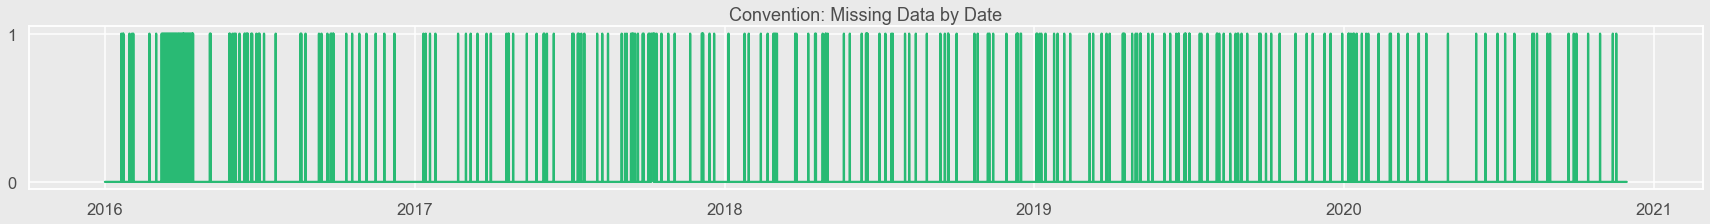

In [6]:
plt.figure(figsize = (30,3))
plt.plot(df_convention['Date et heure de comptage'] ,df_convention[['Débit horaire', 'Taux d\'occupation']].isna().any(axis=1), color=bcg_green)
plt.yticks([0,1])
plt.title('Convention: Missing Data by Date')
plt.show()

We can see that in the case of this dataset, the missing data were relatively sparse, that is to say there weren't many periods of consecutive missing data, and so we can use all 5 years in order to conduct our analysis.

# 2.0 EDA / Feature Engineering

In [7]:
df_analysis = df_convention.copy()

## 2.1 Manage Dates

<p>We firstly separate our datetime information into different degrees of granularity (year, month, week_day and hour) so our model is able to capture seasonality trends on different time scales. We chose set them as categorical value</p>

In [8]:
df_analysis = df_analysis[['Date et heure de comptage', 'Débit horaire', 'Taux d\'occupation']]
df_analysis['year'] = df_analysis['Date et heure de comptage'].dt.year.astype('category')
df_analysis['month'] = df_analysis['Date et heure de comptage'].dt.month.astype('category')
df_analysis['week_day'] = df_analysis['Date et heure de comptage'].dt.weekday.astype('category')
df_analysis['time'] = df_analysis['Date et heure de comptage'].dt.time.astype(str).apply(lambda x: x[:2]).astype('category')
df_analysis.sort_values('Date et heure de comptage', inplace = True)
df_analysis.head()

,Date et heure de comptage,Débit horaire,Taux d'occupation,year,month,week_day,time
0,2016-01-01 01:00:00,243.0,3.03000,2016,1,4,01
1,2016-01-01 02:00:00,354.0,3.99833,2016,1,4,02
2,2016-01-01 03:00:00,386.0,4.49500,2016,1,4,03
3,2016-01-01 04:00:00,309.0,3.63556,2016,1,4,04
4,2016-01-01 05:00:00,291.0,3.16945,2016,1,4,05


<p>Since big events can greatly impact the dynamic of our traffic information (Vacations, Covid-19), we try to encode that influence in some "event columns". </p>
<p>We defined a periods_dict (found in dicts.py) in which we can add time periods and the values we attribute to them </p>

In [9]:
from utils.periods import add_periods

df_analysis.set_index('Date et heure de comptage', inplace = True)
df_analysis = add_periods(df_analysis) # Reads periods_dict and adds the corresponding event columns
df_analysis.reset_index(inplace = True)
display(df_analysis.head())

,Date et heure de comptage,Débit horaire,Taux d'occupation,year,month,week_day,time,lockdown_intensity,vacation
0,2016-01-01 01:00:00,243.0,3.03000,2016,1,4,01,0.0,1.0
1,2016-01-01 02:00:00,354.0,3.99833,2016,1,4,02,0.0,1.0
2,2016-01-01 03:00:00,386.0,4.49500,2016,1,4,03,0.0,1.0
3,2016-01-01 04:00:00,309.0,3.63556,2016,1,4,04,0.0,1.0
4,2016-01-01 05:00:00,291.0,3.16945,2016,1,4,05,0.0,1.0


<p>The two events we chose to add to our model were the official periods for school holidays in France (categorical 1/0), and the official periods for the 2020 Covid-19 lockdowns in France, with their respective intensities (continuous [0,1]).</p>
<p> 

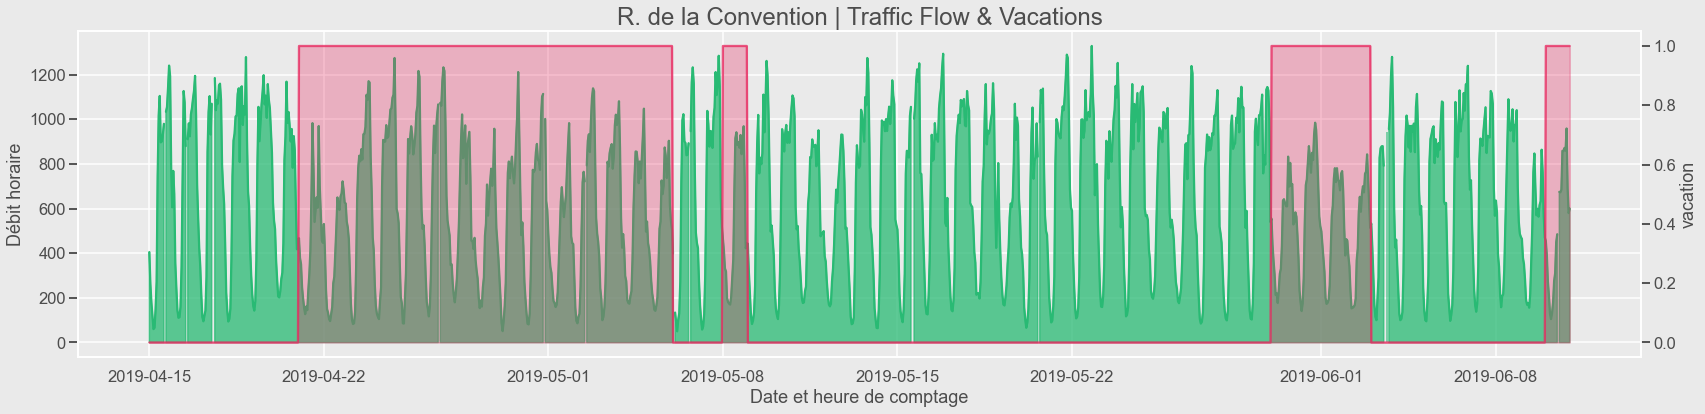

In [10]:
plt.figure(figsize = (28,6))
ax = sns.lineplot(x='Date et heure de comptage', y='Débit horaire', data=df_analysis.set_index('Date et heure de comptage').loc['2019-04-15':'2019-06-10'], alpha=1, color=bcg_green)
ax.fill_between(ax.lines[0].get_xydata()[:,0], ax.lines[0].get_xydata()[:,1], alpha=0.75, color=bcg_green)
ax2 = ax.twinx()
sns.lineplot(x='Date et heure de comptage', y='vacation', data=df_analysis.set_index('Date et heure de comptage').loc['2019-04-15':'2019-06-10'], ax=ax2, alpha=0.75)
ax2.fill_between(ax2.lines[0].get_xydata()[:,0], ax2.lines[0].get_xydata()[:,1],alpha=0.3)
plt.xticks(rotation=45)
plt.title('R. de la Convention | Traffic Flow & Vacations', size=24)
ax2.grid(False)
plt.show()

<p> We can see that holidays, intuitively, end up lowering overal traffic on the street </p>

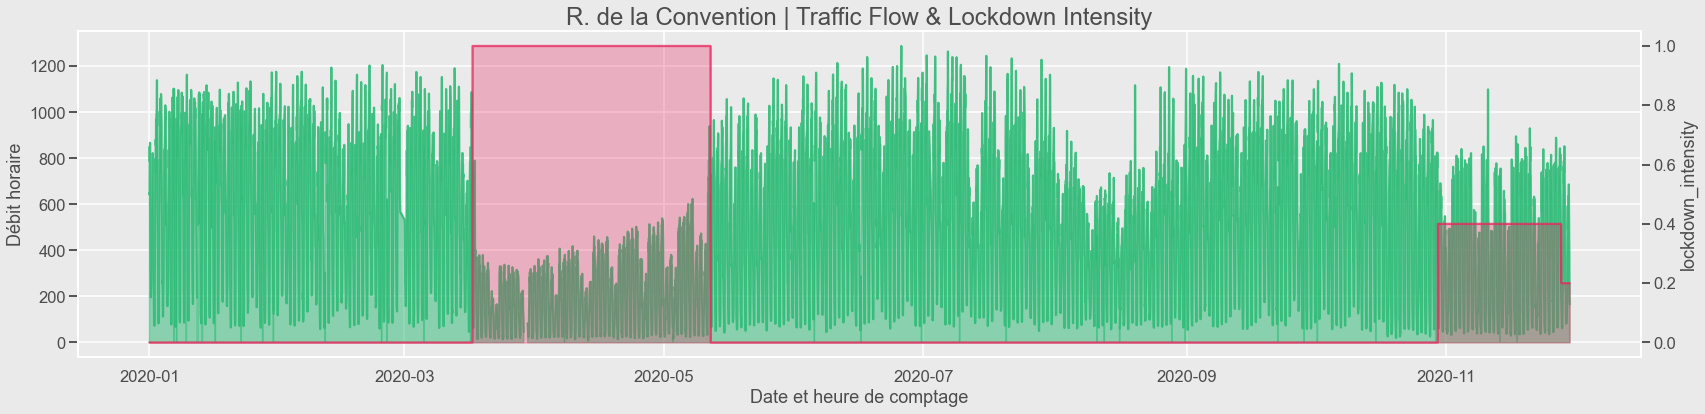

In [11]:
plt.figure(figsize = (28,6))
ax = sns.lineplot(x='Date et heure de comptage', y='Débit horaire', data=df_analysis[df_analysis['year'] == 2020], legend='full', alpha=0.75, color=bcg_green)
ax.fill_between(ax.lines[0].get_xydata()[:,0], ax.lines[0].get_xydata()[:,1], alpha=0.5, color=bcg_green)
ax2 = ax.twinx()
sns.lineplot(x='Date et heure de comptage', y='lockdown_intensity', data=df_analysis[df_analysis['year'] == 2020],ax=ax2, alpha=0.75)
ax2.fill_between(ax2.lines[0].get_xydata()[:,0], ax2.lines[0].get_xydata()[:,1],alpha=0.3)
plt.xticks(rotation=45)
plt.title('R. de la Convention | Traffic Flow & Lockdown Intensity', size=24)
ax2.grid(False)
plt.show()

<p> We established the lockdown intensities by looking at the relative impact both lockdowns had on the historical traffic flow data, by fixing the intensity of the first lockdown to 1, and the second one to 0.4 (meaning we saw an avarage 60% difference on the impact in traffic flow between both lockdowns). We also thought this relative approach made sense because there were some qualitative differences on the implementation of the second lockdown (office work allowed, parks and gardens still open) which could define it as being less intense than the first one. </p>


## 2.2 Add Lag Features

<p>A common approach to time series forecasting with ML algorithms is to add so called 'Lag features', by taking the time series itself, standardized and with a given time lag shift, as a feature for the training of the model.</p>

In [12]:
from utils.create_lag_features import create_lag_features   
df_with_lag_feats = create_lag_features(df_analysis, 'Débit horaire', [7*24])   # Creates lag features with a lag shift of 168 hours (1 week)
df_with_lag_feats[['Débit horaire', 'lag_168']].iloc[-6:-1]

,Débit horaire,lag_168
43143,687.0,-0.281187
43144,593.0,-0.383228
43145,453.0,-0.519284
43146,390.0,-0.766657
43147,185.0,-1.085151


<p> We however did not include this feature in our final model because we noticed it ended up worsening our performances. </p>

In [13]:
df_analysis

,Date et heure de comptage,Débit horaire,Taux d'occupation,year,month,week_day,time,lockdown_intensity,vacation
0,2016-01-01 01:00:00,243.0,3.03000,2016,1,4,01,0.0,1.0
1,2016-01-01 02:00:00,354.0,3.99833,2016,1,4,02,0.0,1.0
2,2016-01-01 03:00:00,386.0,4.49500,2016,1,4,03,0.0,1.0
3,2016-01-01 04:00:00,309.0,3.63556,2016,1,4,04,0.0,1.0
4,2016-01-01 05:00:00,291.0,3.16945,2016,1,4,05,0.0,1.0
...,...,...,...,...,...,...,...,...,...
43144,2020-11-29 20:00:00,593.0,3.71611,2020,11,6,20,0.2,0.0
43145,2020-11-29 21:00:00,453.0,2.26667,2020,11,6,21,0.2,0.0
43146,2020-11-29 22:00:00,390.0,1.80445,2020,11,6,22,0.2,0.0
43147,2020-11-29 23:00:00,185.0,1.37056,2020,11,6,23,0.2,0.0
